In [109]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import warnings
import re

warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8-darkgrid')

# Data Collection With BeautifulSoup

In [111]:
def scrape_hoanghamobile():
    url = "https://hoanghamobile.com/dien-thoai-di-dong"
    response = requests.get(url)

    if response.status_code != 200:
        print(f"Failed to retrieve the webpage. Status code: {response.status_code}")
        return
    
    soup = BeautifulSoup(response.text, "html.parser")
    products = soup.find_all('div', class_='v5-item')
    phone_list = []
    
    for product in products:
        price = int(product.find('div', class_='price').find('strong').get_text(strip=True).replace("₫", "").replace(",", "").strip())
        name = product.find('h3').get_text(strip=True)
        phone_list.append({
            "Product": name,
            "Price": price,
            "Date": datetime.now().strftime("%Y-%m-%d")
        })
    return phone_list

In [112]:
def scrape_cellphones():
    url = "https://www.cellphones.com.vn/mobile.html"
    response = requests.get(url)
    
    if response.status_code != 200:
        print(f"Failed to retrieve the webpage. Status code: {response.status_code}")
        return
    
    soup = BeautifulSoup(response.text, "html.parser")

    phones = soup.find_all("div", class_="product__name")
    prices = soup.find_all("p", class_="product__price--show")

    phone_list = []
    for phone, price in zip(phones, prices):
        price_processed = int(price.text.replace("đ", "").replace(".", "").strip())
        phone_processed = phone.text.strip()
        phone_list.append({
            "Product": phone_processed,
            "Price": price_processed,
            "Date": datetime.now().strftime("%Y-%m-%d")
        })
    return phone_list

In [113]:
def save_data_weekly():
    hoangha_data = scrape_hoanghamobile()
    cellphones_data = scrape_cellphones()

    # Tổng hợp dữ liệu từ cả hai nguồn
    all_data = hoangha_data + cellphones_data
    df = pd.DataFrame(all_data)
    
    if os.path.exists('phone_prices_weekly.csv'):
        df.to_csv('phone_prices_weekly.csv', mode='a', header=False, index=False)
    else:
        df.to_csv('phone_prices_weekly.csv', mode='w', header=True, index=False)

In [114]:
save_data_weekly()

# Data Aggregation and Analysis

In [116]:
# Third Party Dataset 'phone_prices_history.csv' - From BeeCost
# Đọc dữ liệu từ CSV
df = pd.read_csv('phone_prices_history.csv')
# Chuyển đổi cột Date thành datetime
df.Date = pd.to_datetime(df.Date)

In [117]:
df.dtypes

Product            object
Price               int64
Date       datetime64[ns]
dtype: object

In [118]:
df.head(5)

,Product,Price,Date
0,TECNO SPARK 20PRO+,5043000,2024-09-28
1,TECNO SPARK 20PRO+,5056000,2024-09-21
2,TECNO SPARK 20PRO+,4910000,2024-09-14
3,TECNO SPARK 20PRO+,4892000,2024-09-07
4,TECNO SPARK 20PRO+,5087000,2024-08-31


In [119]:
# Tạo cột phân khúc sản phẩm (giá rẻ, tầm trung, cao cấp)
df['Segment'] = pd.cut(df['Price'], bins=[0, 5000000, 15000000, 60000000], labels=["Low", "Mid", "High"])

# Danh sách các hãng điện thoại phổ biến
brands = ['Samsung', 'Apple', 'Xiaomi', 'Huawei', 'Sony', 'Oppo', 'Vivo', 'Realme', 'OnePlus', 'Tecno', 'iPhone']

# Hàm tìm kiếm hãng trong tên điện thoại
def extract_brand(phone_name):
    for brand in brands:
        if re.search(brand, phone_name, re.IGNORECASE):
            return brand
    return 'Other'  # Nếu không tìm thấy hãng nào khớp

# Áp dụng hàm để tạo cột brand
df['Brand'] = df['Product'].apply(extract_brand)

In [120]:
df.head(5)

,Product,Price,Date,Segment,Brand
0,TECNO SPARK 20PRO+,5043000,2024-09-28,Mid,Tecno
1,TECNO SPARK 20PRO+,5056000,2024-09-21,Mid,Tecno
2,TECNO SPARK 20PRO+,4910000,2024-09-14,Low,Tecno
3,TECNO SPARK 20PRO+,4892000,2024-09-07,Low,Tecno
4,TECNO SPARK 20PRO+,5087000,2024-08-31,Mid,Tecno


In [121]:
# Tính giá trung bình theo tuần
df['Week'] = df['Date'].dt.to_period('W')
weekly_avg = df.groupby('Week')['Price'].mean()

# Đặt lại định dạng hiện thị kiểu float
pd.options.display.float_format = '{:,.2f}'.format

In [122]:
# Tính giá trung bình theo tháng
df['Month'] = df['Date'].dt.to_period('M')
monthly_avg = df.groupby('Month')['Price'].mean()

In [123]:
# Tính giá trung bình theo phân khúc
segment_avg = df.groupby(['Segment'])['Price'].mean()

In [124]:
# Hiện thị giá trung bình
print("Giá trung bình theo tuần:")
print(weekly_avg, '\n')

print("Giá trung bình theo tháng:")
print(monthly_avg,  '\n')

print("Giá trung bình theo phân khúc:")
print(segment_avg,  '\n')

Giá trung bình theo tuần:
Week
2023-10-02/2023-10-08   17,239,885.14
2023-10-09/2023-10-15   17,251,912.16
2023-10-16/2023-10-22   17,221,702.70
2023-10-23/2023-10-29   17,219,952.70
2023-10-30/2023-11-05   17,186,418.92
2023-11-06/2023-11-12   17,172,030.41
2023-11-13/2023-11-19   17,169,547.30
2023-11-20/2023-11-26   17,179,945.95
2023-11-27/2023-12-03   17,197,199.32
2023-12-04/2023-12-10   17,210,060.81
2023-12-11/2023-12-17   17,151,341.22
2023-12-18/2023-12-24   17,152,189.19
2023-12-25/2023-12-31   17,172,398.65
2024-01-01/2024-01-07   17,150,854.73
2024-01-08/2024-01-14   17,179,645.27
2024-01-15/2024-01-21   17,186,212.84
2024-01-22/2024-01-28   17,153,168.92
2024-01-29/2024-02-04   17,145,868.24
2024-02-05/2024-02-11   17,113,206.08
2024-02-12/2024-02-18   17,124,760.14
2024-02-19/2024-02-25   17,179,706.08
2024-02-26/2024-03-03   17,237,175.68
2024-03-04/2024-03-10   17,209,037.16
2024-03-11/2024-03-17   17,199,797.30
2024-03-18/2024-03-24   17,226,847.97
2024-03-25/2024-03-

In [125]:
df.head(5)

,Product,Price,Date,Segment,Brand,Week,Month
0,TECNO SPARK 20PRO+,5043000,2024-09-28,Mid,Tecno,2024-09-23/2024-09-29,2024-09
1,TECNO SPARK 20PRO+,5056000,2024-09-21,Mid,Tecno,2024-09-16/2024-09-22,2024-09
2,TECNO SPARK 20PRO+,4910000,2024-09-14,Low,Tecno,2024-09-09/2024-09-15,2024-09
3,TECNO SPARK 20PRO+,4892000,2024-09-07,Low,Tecno,2024-09-02/2024-09-08,2024-09
4,TECNO SPARK 20PRO+,5087000,2024-08-31,Mid,Tecno,2024-08-26/2024-09-01,2024-08


# Data Visualization

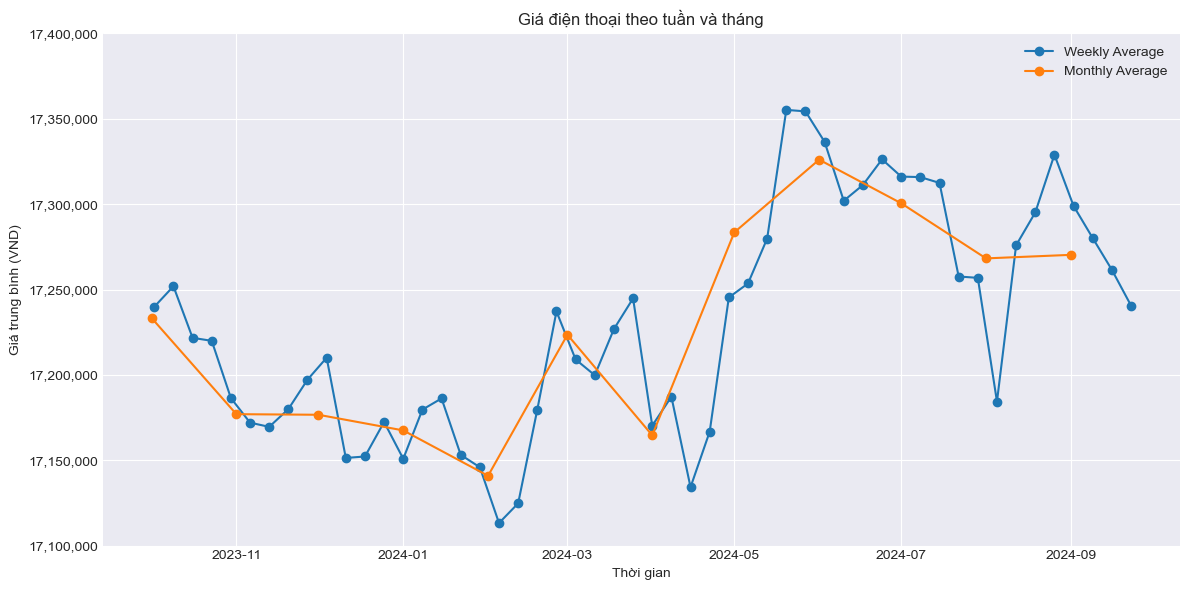

In [127]:
# Vẽ biểu đồ giá theo thời gian (theo tuần và tháng)
plt.figure(figsize=(12, 6))
plt.plot(weekly_avg.index.astype('datetime64[ns]'), weekly_avg.values, label='Weekly Average', marker='o')
plt.plot(monthly_avg.index.astype('datetime64[ns]'), monthly_avg.values, label='Monthly Average', marker='o')

plt.title('Giá điện thoại theo tuần và tháng')
plt.xlabel('Thời gian')
plt.ylabel('Giá trung bình (VND)')

# Đặt định dạng cho trục y và x
yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{int(tick):,.0f}' for tick in yticks])
plt.xticks(rotation=0)

plt.legend()
plt.tight_layout()
plt.show()


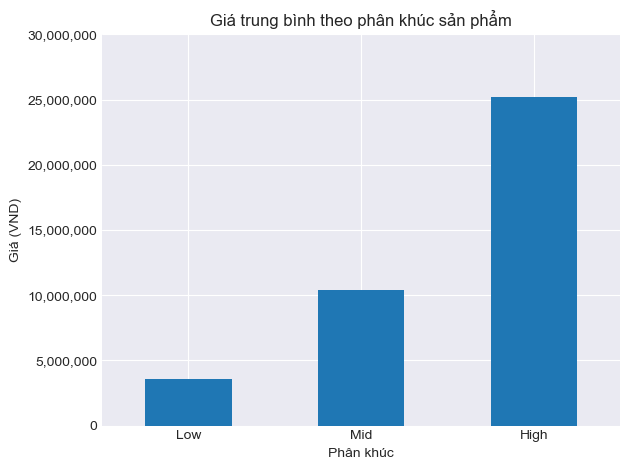

In [128]:
# Vẽ biểu đồ phân khúc sản phẩm
segment_avg.plot(kind='bar', title='Giá trung bình theo phân khúc sản phẩm', ylabel='Giá (VND)', xlabel='Phân khúc')
plt.xticks(rotation=0)
yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{int(tick):,.0f}' for tick in yticks])
plt.tight_layout()
plt.show()

In [129]:
df.head(10)

,Product,Price,Date,Segment,Brand,Week,Month
0,TECNO SPARK 20PRO+,5043000,2024-09-28,Mid,Tecno,2024-09-23/2024-09-29,2024-09
1,TECNO SPARK 20PRO+,5056000,2024-09-21,Mid,Tecno,2024-09-16/2024-09-22,2024-09
2,TECNO SPARK 20PRO+,4910000,2024-09-14,Low,Tecno,2024-09-09/2024-09-15,2024-09
3,TECNO SPARK 20PRO+,4892000,2024-09-07,Low,Tecno,2024-09-02/2024-09-08,2024-09
4,TECNO SPARK 20PRO+,5087000,2024-08-31,Mid,Tecno,2024-08-26/2024-09-01,2024-08
5,TECNO SPARK 20PRO+,5088000,2024-08-24,Mid,Tecno,2024-08-19/2024-08-25,2024-08
6,TECNO SPARK 20PRO+,4966000,2024-08-17,Low,Tecno,2024-08-12/2024-08-18,2024-08
7,TECNO SPARK 20PRO+,5116000,2024-08-10,Mid,Tecno,2024-08-05/2024-08-11,2024-08
8,TECNO SPARK 20PRO+,5088000,2024-08-03,Mid,Tecno,2024-07-29/2024-08-04,2024-08
9,TECNO SPARK 20PRO+,5104000,2024-07-27,Mid,Tecno,2024-07-22/2024-07-28,2024-07


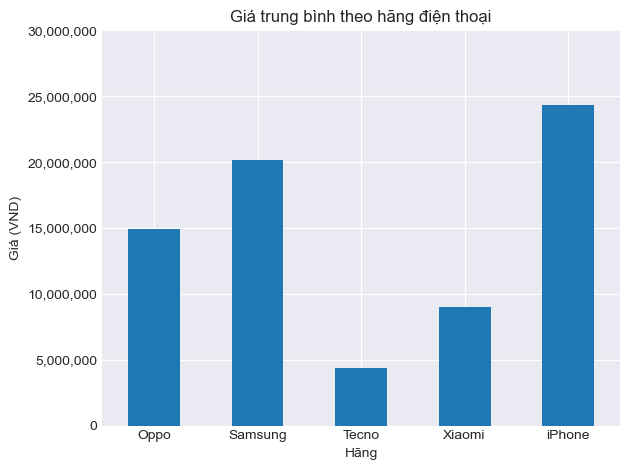

In [130]:
# Vẽ biểu đồ hãng
brand_avg = df.groupby(['Brand'])['Price'].mean()
brand_avg.plot(kind='bar', title='Giá trung bình theo hãng điện thoại', ylabel='Giá (VND)', xlabel='Hãng')
plt.xticks(rotation=0)
yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{int(tick):,.0f}' for tick in yticks])
plt.tight_layout()
plt.show()

In [131]:
df.Brand.unique()

array(['Tecno', 'Samsung', 'Oppo', 'iPhone', 'Xiaomi'], dtype=object)

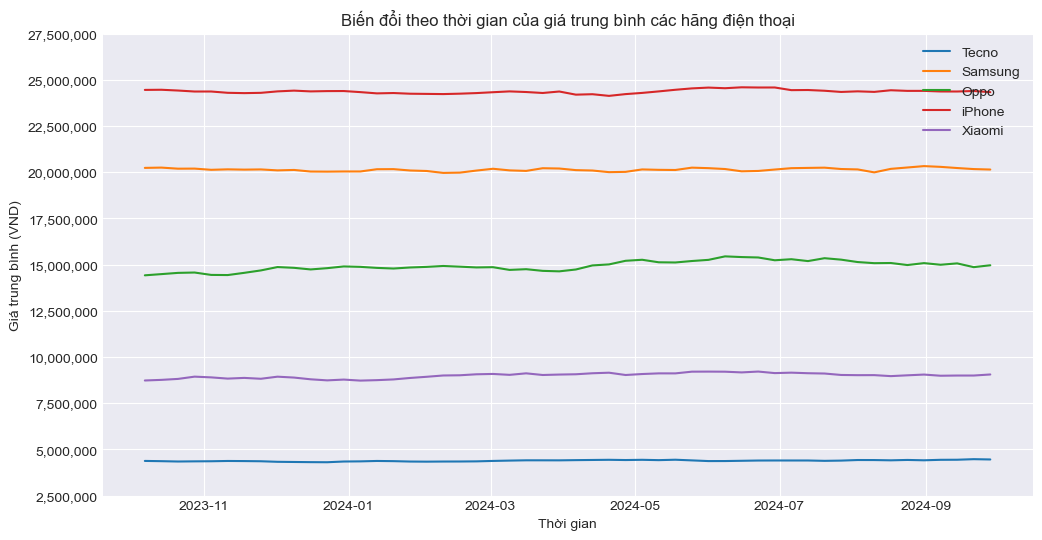

In [132]:
brands = df.Brand.unique()
plt.figure(figsize=(12, 6))
for brand in brands:
    data = df.loc[df.Brand == brand].groupby('Date')['Price'].mean()
    plt.plot(data.index, data, label=brand)
yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{int(tick):,.0f}' for tick in yticks])
plt.xticks(rotation=0)
plt.legend()
plt.title('Biến đổi theo thời gian của giá trung bình các hãng điện thoại')
plt.xlabel('Thời gian')
plt.ylabel('Giá trung bình (VND)');

In [133]:
for brand in brands:
    data = df.loc[df.Brand == brand]['Product'].unique()
    print(data)

['TECNO SPARK 20PRO+' 'TECNO SPARK Go 2024 4GB 64GB'
 'Điện thoại Tecno Camon 30 8GB/256GB' 'Tecno Pova 6 (8GB/256GB)'
 'TECNO SPARK 20 8GB 128GB' 'TECNO POVA 5 8GB 128GB'
 'Điện thoại Tecno Camon 30 12GB/256GB']
['Samsung Galaxy S24 Plus 12GB 512GB' 'Samsung Galaxy S23 FE 5G 8GB 128GB'
 'Samsung Galaxy S24 Plus 12GB 256GB' 'Samsung Galaxy M55 (12GB 256GB)'
 'Samsung Galaxy S23 FE 8GB 256GB' 'Samsung Galaxy S23 Ultra 12GB 512GB'
 'Samsung Galaxy S24 Ultra 12GB 256GB'
 'Samsung Galaxy S23 8GB 128GB - Chỉ có tại CellphoneS'
 'Samsung Galaxy Z Fold6' 'Samsung Galaxy A15 LTE 8GB 128GB'
 'Samsung Galaxy Z Flip6']
['OPPO Reno10 Pro+ 5G 12GB 256GB'
 'OPPO Find X5 Pro 12GB 256GB - Giá mới chỉ có tại CellphoneS']
['iPhone 16 128GB | Chính hãng VN/A'
 'iPhone 16 Pro Max 256GB | Chính hãng VN/A'
 'iPhone 16 Pro 128GB | Chính hãng VN/A'
 'iPhone 15 Pro Max 256GB | Chính hãng VN/A'
 'iPhone 13 128GB | Chính hãng VN/A' 'iPhone 15 128GB | Chính hãng VN/A'
 'iPhone 14 Pro Max 128GB | Chính hãng VN/A'


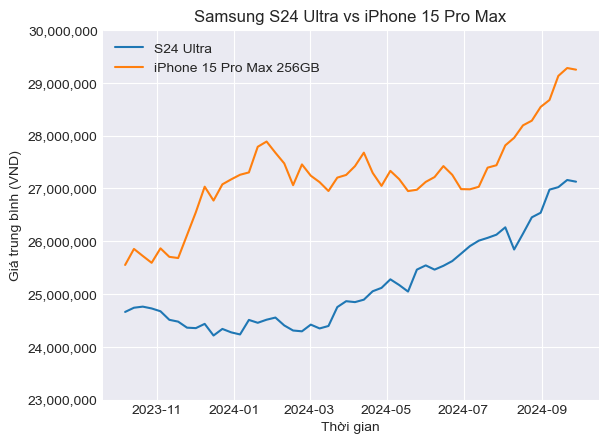

In [134]:
S24 = df.loc[df.Product == 'Samsung Galaxy S24 Ultra 12GB 256GB'].groupby('Date')['Price'].mean()
ip15_Pro_Max_256 = df.loc[df.Product ==  'iPhone 15 Pro Max 256GB | Chính hãng VN/A'].groupby('Date')['Price'].mean()

plt.plot(S24.index, S24, label='S24 Ultra')
plt.plot(ip15_Pro_Max_256.index, ip15_Pro_Max_256, label='iPhone 15 Pro Max 256GB')

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{int(tick):,.0f}' for tick in yticks])
plt.xticks(rotation=0)

plt.legend()
plt.title('Samsung S24 Ultra vs iPhone 15 Pro Max')
plt.xlabel('Thời gian')
plt.ylabel('Giá trung bình (VND)');

    

# Regression Analysis

In [136]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Chuyển đổi cột Date thành số tuần (numeric)
df['Date_Numeric'] = df['Date'].dt.strftime('%Y%U').astype(int)

# Chọn các biến cho mô hình hồi quy
X = df[['Date_Numeric']]
y = df['Price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mô hình hồi quy
model = LinearRegression()
model.fit(X_train, y_train)

# Dự đoán giá điện thoại trong tương lai
future_weeks = pd.DataFrame({'Date_Numeric': range(df['Date_Numeric'].max(), df['Date_Numeric'].max() + 10)})
predictions = model.predict(future_weeks)
print(predictions)

[17221429.05580455 17222076.81622976 17222724.57665496 17223372.33708017
 17224020.09750538 17224667.85793059 17225315.61835578 17225963.37878099
 17226611.1392062  17227258.89963141]


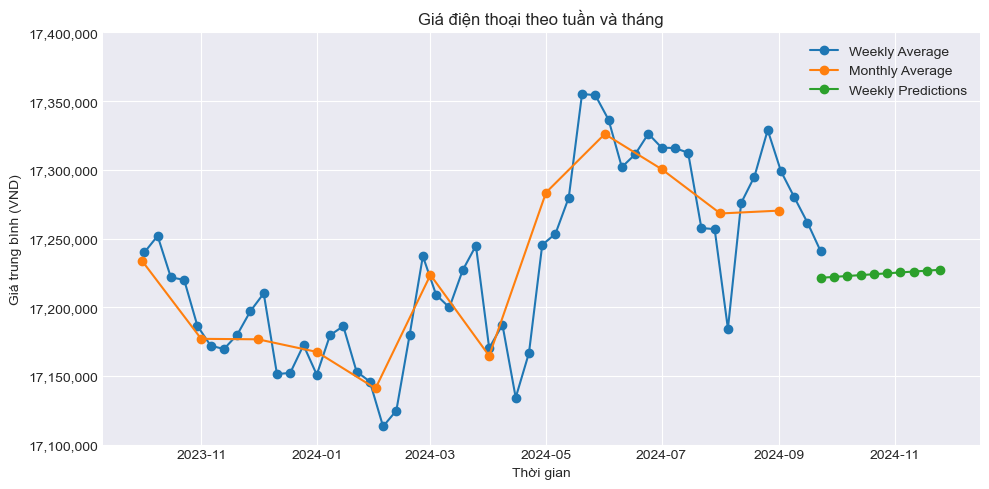

In [137]:
# VISUALUIZE PREDICTION WEEKLY AVERAGE

# Hàm chuyển date_numeric về datetime
def convert_to_date(date_numeric):
    year = date_numeric // 100  # Lấy phần năm
    week = date_numeric % 100    # Lấy phần tuần
    # Tạo ngày đầu tiên của tuần
    return pd.to_datetime(f'{year}-W{week}-1', format='%Y-W%U-%w')

# Vẽ biểu đồ giá theo thời gian (theo tuần và tháng)
plt.figure(figsize=(10, 5))
plt.plot(weekly_avg.index.astype('datetime64[ns]'), weekly_avg.values, label='Weekly Average', marker='o')
plt.plot(monthly_avg.index.astype('datetime64[ns]'), monthly_avg.values, label='Monthly Average', marker='o')
plt.plot(future_weeks['Date_Numeric'].apply(convert_to_date), predictions, label='Weekly Predictions', marker='o')

plt.title('Giá điện thoại theo tuần và tháng')
plt.xlabel('Thời gian')
plt.ylabel('Giá trung bình (VND)')

# Đặt định dạng cho trục y và x
yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{int(tick):,.0f}' for tick in yticks])
plt.xticks(rotation=0)

plt.legend()
plt.tight_layout()
plt.show()
